<a href="https://colab.research.google.com/github/ajainuary/jigsaw-solver/blob/main/Jigsaw_Puzzle_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installation dependencies
!pip install numpy==1.18.1 matplotlib==3.1.3 scipy==1.4.1 sklearn
!pip install cvxpy==1.0.25 scikit-image==0.16.2

     |████████████████████████████████| 20.2MB 1.3MB/s 
     |████████████████████████████████| 13.1MB 32.4MB/s 
ERROR: tensorflow 2.4.0 has requirement numpy~=1.19.2, but you'll have numpy 1.18.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


     |████████████████████████████████| 911kB 5.3MB/s 
  Created wheel for cvxpy: filename=cvxpy-1.0.25-cp36-cp36m-linux_x86_64.whl size=2044800 sha256=a64a5430c052c31b93e470566b6e54f816a80895588d819ef49febc6616403a6
  Stored in directory: /root/.cache/pip/wheels/f1/b0/c3/0d3e98435c5070047e033ead500eb4f93a87c4f3ab6ea6dc1e
Successfully built cvxpy
  Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [2]:
# Compatibility imports
from __future__ import print_function, division

# Imports
import os 
import sys
import random

import numpy as np 
import cvxpy as cp 

import matplotlib.pyplot as plt 

# Modules specific to problems 
from sklearn.datasets import make_circles # For problem 2 (Best Polyhedron) 
from scipy.spatial import ConvexHull # For problem 3 (Largest Ball in Polyhedron)
from scipy.linalg import null_space # For problem 4 (Illumination)
import matplotlib.cbook as cbook # For problem 5 (Jigsaw)
from skimage.transform import resize # For problem 5 (Jigsaw)
from scipy.spatial import distance
% matplotlib inline

In [3]:
class Jigsaw():
  def __init__(self,path=None):
    super(Jigsaw,self).__init__()
    """
      Initialize your Jigsaw puzzle, you can provide path to an image or we will load the default image
    """
    if path is None:  # Load default image  
      with cbook.get_sample_data('grace_hopper.png') as image_file:
        self.image = plt.imread(image_file)
    else:
      self.image = plt.imread(path)  # Load image of your choice

    self.original_size = self.image.shape[0:2] #Store the original size of the image
    self.new_size = (500,500) # Store new image size, 500x500
    self.rows = 5 # number of rows in jigsaw puzzle
    self.cols = 5 # number of cols in jigsaw puzzle

    # RxCxHxWx3 numpy array storing the jigsaw puzzle
    self.jigsaw = self.create_jigsaw_puzzle(self.image,self.new_size,self.rows,self.cols)

  
  def image2patches(self,image,new_size,rows,cols):
    """
      This function converts an image to patches for jigsaw puzzle
      @param: image -> input image
      @param: new_size -> shape to which image will be resized
      @param: rows -> number of rows in the jigsaw puzzle
      @param: rows -> number of cols in the jigsaw puzzle

      @returns: patches -> RxCxHxWx3 numpy array storing the jigsaw puzzle's patches
    """

    image = resize(image,self.new_size) # resize the original image 
    patches = np.zeros((self.rows,self.cols,self.new_size[0]//self.rows,self.new_size[1]//self.cols,3)) # store the jigsaw puzzle here
    for i in range(self.rows): # for every row of jigsaw
      for j in range(self.cols): # for every col of jigsaw
        patches[i,j,:,:,:] = self.image[i*self.new_size[0]//self.rows:(i+1)*self.new_size[0]//self.rows,j*self.new_size[0]//self.cols:(j+1)*self.new_size[0]//self.cols,:]
    return patches 

  def patches2image(self,patches,original_size):
    """
      This function recreates images from patches
      @param: patches -> RxCxHxWx3 numpy array storing the jigsaw puzzle's patches
      @param: orignal_size -> shape to which image will be resized

      @returns: image -> output image 
    """
    R,C,H,W,_ = patches.shape
    image = np.zeros((R*H,C*W,3))
    for i in range(R):
      for j in range(C):
        image[i*H:(i+1)*H,j*W:(j+1)*W,:] = patches[i,j,:,:,:] 
    
    image = resize(image,original_size) 
    return image 

  def create_jigsaw_puzzle(self,image,new_size,rows,cols):
    patches = self.image2patches(image,new_size,rows,cols)
    R,C,H,W,_ = patches.shape
    patches = patches.reshape((-1,H,W,3))
    patches = patches[np.random.permutation(R*C),...].reshape((R,C,H,W,3))
    return patches

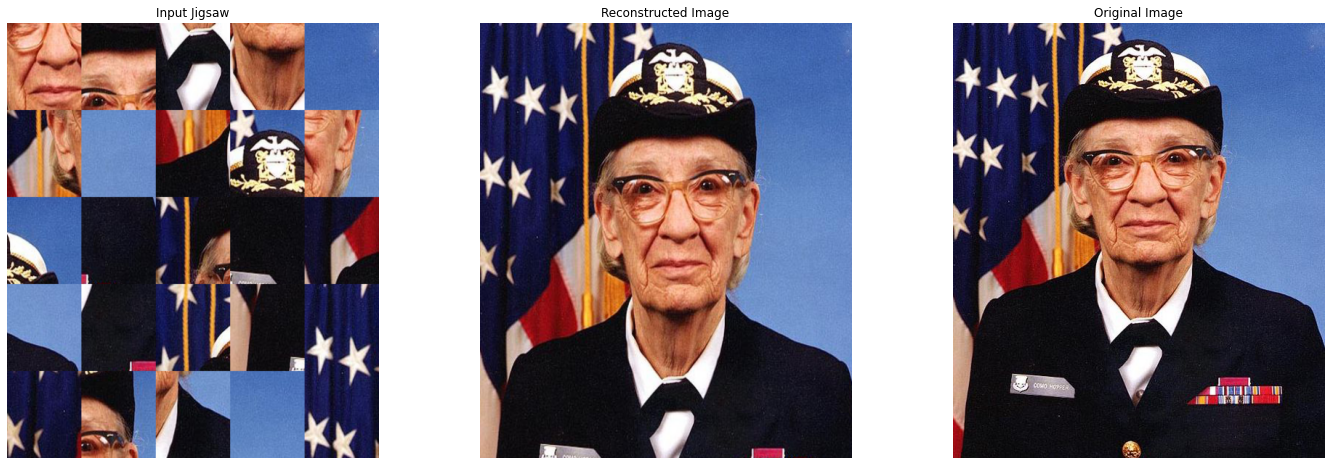

In [6]:
 # Create your jigsaw puzzle solver here
class JigsawSolver(Jigsaw):
  def __init__(self,*args,**kwargs):
    super(JigsawSolver,self).__init__()
    pass

  def plot(self):
    fig = plt.figure(figsize=(24,8))
    ax1 = fig.add_subplot(131)
    ax1.imshow(self.patches2image(self.jigsaw,self.original_size))
    ax1.axis('off')
    ax1.set_title("Input Jigsaw")

    # Create your plot here
    ax2 = fig.add_subplot(132)
    ax2.imshow(self.recon_image)
    ax2.axis('off')
    ax2.set_title("Reconstructed Image")


    ax3 = fig.add_subplot(133)
    ax3.imshow(self.image)
    ax3.axis('off')
    ax3.set_title("Original Image")

    plt.show()

  def solve(self):
    """
      Write your solver here
    """
    def D_IJO(i_1, j_1, i_2, j_2, o):
        """Calculates the Mahalanobis Gradient Distance ref. https://github.com/mhmoed/jigsaw"""
        num_rotations = [3, 0, 1, 2]
        i1 = np.rot90(self.jigsaw[i_1][j_1], num_rotations[o])
        i2 = np.rot90(self.jigsaw[i_2][j_2], num_rotations[o])
        g = i1[:, -1] - i1[:, -2]
        m = g.mean(axis=0)
        s = np.cov(g.T) + np.eye(3)
        h = i2[:, 1] - i1[:, -1]
        return sum(distance.mahalanobis(row, m, np.linalg.inv(s)) for row in h)
    pairwise_match = []
    for i_1 in range(5):
        for j_1 in range(5):
            for i_2 in range(5):
                for j_2 in range(5):
                    for o in range(4):
                        pairwise_match.append((i_1,j_1,i_2,j_2,o))
    D = {}
    for i_1 in range(5):
        for j_1 in range(5):
            for i_2 in range(5):
                for j_2 in range(5):
                    for o in range(4):
                        D[(i_1,j_1,i_2,j_2,o)] = D_IJO(i_1, j_1, i_2, j_2, o)
    W = {}
    for x in pairwise_match:
        i_1,j_1,i_2,j_2,o = x
        min_row = 1e7
        for i in range(5):
            for j in range(5):
                if i_2 != i and j_2 != j:
                    min_row = min(min_row, D[(i_1, j_1, i, j, o)])
        min_col = 1e7
        for i in range(5):
            for j in range(5):
                if i_1 != i and j_1 != j:
                    min_col = min(min_col, D[(i, j, i_2, j_2, o)])
        W[x] = min(min_row, min_col) / D[(i_1, j_1, i_2, j_2, o)]
    A = {}
    for x in pairwise_match:
        i_1,j_1,i_2,j_2,o = x
        if (i_1, j_1, o) in A:
            i, j = A[(i_1, j_1, o)]
            if D[(i,j,i_2,j_2,o)] > D[x]:
                A[(i_1, j_1, o)] = (i_2, j_2)
        else:
            A[(i_1, j_1, o)] = (i_2, j_2)
    h_x = cp.Variable((625, 4))
    h_y = cp.Variable((625, 4))
    x = cp.Variable((5,5))
    y = cp.Variable((5,5))
    a, b = 0, 0
    constraints_x = []
    constraints_y = []
    DELTA_X = [0, -1, 0, 1]
    DELTA_Y = [1, 0, -1, 0]
    for key in A:
        i_1, j_1,o = key
        i_2, j_2 = A[key]
        a += h_x[25*(5*i_1+j_1)+5*i_2+j_2][o]*W[(i_1,j_1,i_2,j_2,o)]
        b += h_y[25*(5*i_1+j_1)+5*i_2+j_2][o]*W[(i_1,j_1,i_2,j_2,o)]
        constraints_x.append(h_x[25*(5*i_1+j_1)+5*i_2+j_2][o] >= x[i_1,j_1] - x[i_2,j_2] - DELTA_X[o])
        constraints_x.append(h_x[25*(5*i_1+j_1)+5*i_2+j_2][o] >= x[i_2,j_2] - x[i_1,j_1] + DELTA_X[o])
        constraints_y.append(h_y[25*(5*i_1+j_1)+5*i_2+j_2][o] >= y[i_1,j_1] - y[i_2,j_2] - DELTA_Y[o])
        constraints_y.append(h_y[25*(5*i_1+j_1)+5*i_2+j_2][o] >= y[i_2,j_2] - y[i_1,j_1] + DELTA_Y[o])
    prob = cp.Problem(cp.Minimize(a), constraints_x)
    prob.solve(solver=cp.ECOS)  # Returns the optimal value.
    prob = cp.Problem(cp.Minimize(b), constraints_y)
    prob.solve(solver=cp.ECOS)  # Returns the optimal value.
    old_x, old_y = None, None
    while (old_x is None and old_y is None) or not (np.array_equal(old_x, x.value) and np.array_equal(old_y, y.value)):
        old_x = x.value
        old_y = y.value
        R = []
        for key in A:
            i_1, j_1,o = key
            i_2, j_2 = A[key]
            if abs(h_x.value[25*(5*i_1+j_1)+5*i_2+j_2][o]) > 1e-2:
                R.append((i_1,j_1,i_2,j_2,o))
            if abs(h_y.value[25*(5*i_1+j_1)+5*i_2+j_2][o]) > 1e-2:
                R.append((i_1,j_1,i_2,j_2,o))
        tmp = []
        for x in pairwise_match:
            if not (x in R):
                tmp.append(x)
        pairwise_match = tmp
        A = {}
        for x in pairwise_match:
            i_1,j_1,i_2,j_2,o = x
            if (i_1, j_1, o) in A:
                i, j = A[(i_1, j_1, o)]
                if D[(i,j,i_2,j_2,o)] > D[x]:
                    A[(i_1, j_1, o)] = (i_2, j_2)
            else:
                A[(i_1, j_1, o)] = (i_2, j_2)
        h_x = cp.Variable((625, 4))
        h_y = cp.Variable((625, 4))
        x = cp.Variable((5,5))
        y = cp.Variable((5,5))
        a, b = 0, 0
        constraints_x = []
        constraints_y = []
        DELTA_X = [0, -1, 0, 1]
        DELTA_Y = [1, 0, -1, 0]
        for key in A:
            i_1, j_1,o = key
            i_2, j_2 = A[key]
            a += h_x[25*(5*i_1+j_1)+5*i_2+j_2][o]*W[(i_1,j_1,i_2,j_2,o)]
            b += h_y[25*(5*i_1+j_1)+5*i_2+j_2][o]*W[(i_1,j_1,i_2,j_2,o)]
            constraints_x.append(h_x[25*(5*i_1+j_1)+5*i_2+j_2][o] >= x[i_1,j_1] - x[i_2,j_2] - DELTA_X[o])
            constraints_x.append(h_x[25*(5*i_1+j_1)+5*i_2+j_2][o] >= x[i_2,j_2] - x[i_1,j_1] + DELTA_X[o])
            constraints_y.append(h_y[25*(5*i_1+j_1)+5*i_2+j_2][o] >= y[i_1,j_1] - y[i_2,j_2] - DELTA_Y[o])
            constraints_y.append(h_y[25*(5*i_1+j_1)+5*i_2+j_2][o] >= y[i_2,j_2] - y[i_1,j_1] + DELTA_Y[o])
        prob = cp.Problem(cp.Minimize(a), constraints_x)
        prob.solve(solver=cp.ECOS)  # Returns the optimal value.
        prob = cp.Problem(cp.Minimize(b), constraints_y)
        prob.solve(solver=cp.ECOS)
    x = np.round(x.value);
    y = np.round(y.value);
    patches = []
    for i in range(5):
        for j in range(5):
            patches.append((x[i][j], y[i][j], (i,j)))
    patches.sort()
    final_img = np.zeros(self.jigsaw.shape)
    tp1, tp2 = 0, 0
    for i in range(5):
        for j in range(5):
            idx = patches[i + j*5][2]
            final_img[i][j] = self.jigsaw[idx[0]][idx[1]]
    self.recon_image = self.patches2image(final_img, self.original_size)
solver = JigsawSolver(path=None)
solver.solve()
solver.plot()